In [357]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from datetime import datetime

from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
from sklearn.metrics import mean_absolute_error
import os

from sklearn.model_selection import ParameterGrid


# Autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [274]:
data = pd.read_csv('../raw_data/inViales_completa.csv')

# Drop duplicates
data = data[data.drop(columns='folio').duplicated() == False]


# FOR NOW DROP THE 'D' CLASS IN codigo_cierre
data = data[(data['codigo_cierre'] == 'D') == False]


# Drop unimportant columns
data = data.drop(columns=['folio', 'fecha_cierre', 'hora_cierre', 'alcaldia_cierre', 'clas_con_f_alarma', 'colonia', 'tipo_incidente_c4'])

#QUitar espacios a alcaldías, y poner guiones bajos
data['alcaldia_inicio'] = data['alcaldia_inicio'].apply(lambda x: x.replace(' ', '_') if isinstance(x, str) else x)


# alcaldia_inicio imputer
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent') 
imputer.fit(data[['alcaldia_inicio']])
data[['alcaldia_inicio']] = imputer.transform(data[['alcaldia_inicio']])


# hora_creacion imputer
imputer = SimpleImputer(strategy='most_frequent')
imputer.fit(data[['hora_creacion']])
data[['hora_creacion']] = imputer.transform(data[['hora_creacion']])


# hora_pico
data['hora_creacion'] = pd.to_timedelta(data['hora_creacion'])
data['hora_creacion'] = data['hora_creacion'].dt.total_seconds() / (60 * 60)

# Create sin & cos columns to help Machine Learning algorithm to capture this cyclicity
data['sin_enc_hora_creacion'] = np.sin(2*np.pi*data.hora_creacion/24) # 12 months in a year
data['cos_enc_hora_creacion'] = np.cos(2*np.pi*data.hora_creacion/24)


# Convierte la columna 'fecha_creacion' al formato de fecha
data['fecha_creacion'] = pd.to_datetime(data['fecha_creacion'])

# Crea nuevas columnas para día, mes, año y semana
data['dia'] = data['fecha_creacion'].dt.day
data['mes'] = data['fecha_creacion'].dt.month
data['año'] = data['fecha_creacion'].dt.year
data['semana'] = data['fecha_creacion'].dt.isocalendar().week

data['sin_enc_fecha_creacion'] = np.sin(2 * np.pi * data['fecha_creacion'].dt.dayofyear / 365)
data['cos_enc_fecha_creacion'] = np.cos(2 * np.pi *  data['fecha_creacion'].dt.dayofyear / 365)



# incidente_c4 class reduction
incidente_c4_dict = {
    'Incidente de tránsito': 'Choque sin lesionados',
    'Accidente automovilístico': 'Choque sin lesionados',
    'Choque con prensados': 'Choque con lesionados',
    'Persona atropellada': 'Atropellado',
    'Volcadura': 'Volcadura',
    'Monopatín': 'Ciclista',
    'Vehiculo atrapado': 'Vehículo atrapadovarado',
    'Vehiculo desbarrancado': 'Vehículo atrapadovarado',
    'Ferroviario': 'Vehículo atrapadovarado'
}
data['incidente_c4'] = data['incidente_c4'].replace(incidente_c4_dict)



# tipo_entrada class reduction
tipo_entrada_dict = {
    'LLAMADA APP911': 'LLAMADA DEL 911',
    'LLAMADA DEL 066': 'LLAMADA DEL 911',
    'BOTÓN DE AUXILIO': 'BOTÓN DE AUXILIO',
    'ZELLO': 'RADIO',
    'LECTOR DE PLACAS': 'CÁMARA',
    'APLICATIVOS': 'RADIO',
}
data['tipo_entrada'] = data['tipo_entrada'].replace(tipo_entrada_dict)


# tipo_entrada imputer
data['tipo_entrada'].fillna('LLAMADA DEL 911', inplace=True)


# OHE

# tipo_incidente C4 encoder
ohe = OneHotEncoder(sparse_output= False, drop='if_binary')
ohe.fit(data[['incidente_c4']])
data[ohe.get_feature_names_out()] = ohe.transform(data[['incidente_c4']])
data.drop(columns = ['incidente_c4'], inplace=True)


# Create Binary class for 'A' vs 'I','N','F'
codigo_cierre_binario = {
    'A' : 1,
    'I' : 0,
    'N' : 0,
    'F' : 0
}
data['codigo_cierre_binario'] = data['codigo_cierre'].replace(codigo_cierre_binario)


# export to csv
# data.to_csv('data911.csv', index=False)

In [275]:
pd.set_option('display.max_columns', len(data.columns))
data.head()

,fecha_creacion,hora_creacion,dia_semana,alcaldia_inicio,latitud,longitud,codigo_cierre,tipo_entrada,sin_enc_hora_creacion,cos_enc_hora_creacion,dia,mes,año,semana,sin_enc_fecha_creacion,cos_enc_fecha_creacion,incidente_c4_Atropellado,incidente_c4_Choque con lesionados,incidente_c4_Choque sin lesionados,incidente_c4_Ciclista,incidente_c4_Motociclista,incidente_c4_Otros,incidente_c4_Persona atrapada / desbarrancada,incidente_c4_Vehículo atrapadovarado,incidente_c4_Volcadura,codigo_cierre_binario
0,2014-01-01,13.413333,Miércoles,IZTAPALAPA,19.38090,-99.06104,A,LLAMADA DEL 911,-0.361625,-0.932324,1,1,2014,1,1.721336e-02,0.999852,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,2014-01-01,21.749722,Miércoles,GUSTAVO_A._MADERO,19.49053,-99.10342,A,LLAMADA DEL 911,-0.555631,0.831429,1,1,2014,1,1.721336e-02,0.999852,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,2013-12-31,22.053611,Martes,IZTAPALAPA,19.32276,-99.04830,I,RADIO,-0.487796,0.872958,31,12,2013,1,6.432491e-16,1.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,2013-12-31,22.748056,Martes,IZTAPALAPA,19.31469,-99.07113,I,LLAMADA DEL 911,-0.321921,0.946766,31,12,2013,1,6.432491e-16,1.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,2014-01-01,21.761944,Miércoles,ALVARO_OBREGON,19.36336,-99.19104,A,LLAMADA DEL 911,-0.552967,0.833203,1,1,2014,1,1.721336e-02,0.999852,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [276]:
data2 = data.drop(['fecha_creacion'], axis=1)
data2.head()

,hora_creacion,dia_semana,alcaldia_inicio,latitud,longitud,codigo_cierre,tipo_entrada,sin_enc_hora_creacion,cos_enc_hora_creacion,dia,mes,año,semana,sin_enc_fecha_creacion,cos_enc_fecha_creacion,incidente_c4_Atropellado,incidente_c4_Choque con lesionados,incidente_c4_Choque sin lesionados,incidente_c4_Ciclista,incidente_c4_Motociclista,incidente_c4_Otros,incidente_c4_Persona atrapada / desbarrancada,incidente_c4_Vehículo atrapadovarado,incidente_c4_Volcadura,codigo_cierre_binario
0,13.413333,Miércoles,IZTAPALAPA,19.38090,-99.06104,A,LLAMADA DEL 911,-0.361625,-0.932324,1,1,2014,1,1.721336e-02,0.999852,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,21.749722,Miércoles,GUSTAVO_A._MADERO,19.49053,-99.10342,A,LLAMADA DEL 911,-0.555631,0.831429,1,1,2014,1,1.721336e-02,0.999852,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,22.053611,Martes,IZTAPALAPA,19.32276,-99.04830,I,RADIO,-0.487796,0.872958,31,12,2013,1,6.432491e-16,1.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,22.748056,Martes,IZTAPALAPA,19.31469,-99.07113,I,LLAMADA DEL 911,-0.321921,0.946766,31,12,2013,1,6.432491e-16,1.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,21.761944,Miércoles,ALVARO_OBREGON,19.36336,-99.19104,A,LLAMADA DEL 911,-0.552967,0.833203,1,1,2014,1,1.721336e-02,0.999852,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [277]:
incidentes_alcaldia = data2.groupby('alcaldia_inicio').sum()[['incidente_c4_Atropellado', 'incidente_c4_Choque con lesionados',
                                                                             'incidente_c4_Choque sin lesionados', 'incidente_c4_Ciclista',
                                                                             'incidente_c4_Motociclista', 'incidente_c4_Otros',
                                                                             'incidente_c4_Persona atrapada / desbarrancada',
                                                                             'incidente_c4_Vehículo atrapadovarado', 'incidente_c4_Volcadura']]

incidentes_alcaldia

,incidente_c4_Atropellado,incidente_c4_Choque con lesionados,incidente_c4_Choque sin lesionados,incidente_c4_Ciclista,incidente_c4_Motociclista,incidente_c4_Otros,incidente_c4_Persona atrapada / desbarrancada,incidente_c4_Vehículo atrapadovarado,incidente_c4_Volcadura
alcaldia_inicio,,,,,,,,,
ALVARO_OBREGON,8137.0,16945.0,53900.0,264.0,4850.0,175.0,494.0,268.0,1602.0
AZCAPOTZALCO,6152.0,11540.0,29753.0,374.0,2498.0,92.0,192.0,128.0,632.0
BENITO_JUAREZ,9738.0,19989.0,54208.0,713.0,3731.0,172.0,953.0,228.0,1225.0
COYOACAN,9913.0,19302.0,58571.0,586.0,4189.0,120.0,380.0,203.0,1211.0
CUAJIMALPA_DE_MORELOS,1909.0,5759.0,13009.0,90.0,1443.0,81.0,176.0,161.0,2241.0
CUAUHTEMOC,21054.0,28804.0,67379.0,1506.0,7285.0,301.0,1783.0,352.0,1193.0
GUSTAVO_A._MADERO,15224.0,28115.0,76465.0,635.0,6947.0,242.0,419.0,296.0,1805.0
IZTACALCO,6761.0,12154.0,30960.0,319.0,2818.0,78.0,244.0,117.0,551.0
IZTAPALAPA,23853.0,37534.0,118583.0,905.0,10068.0,256.0,419.0,455.0,2352.0


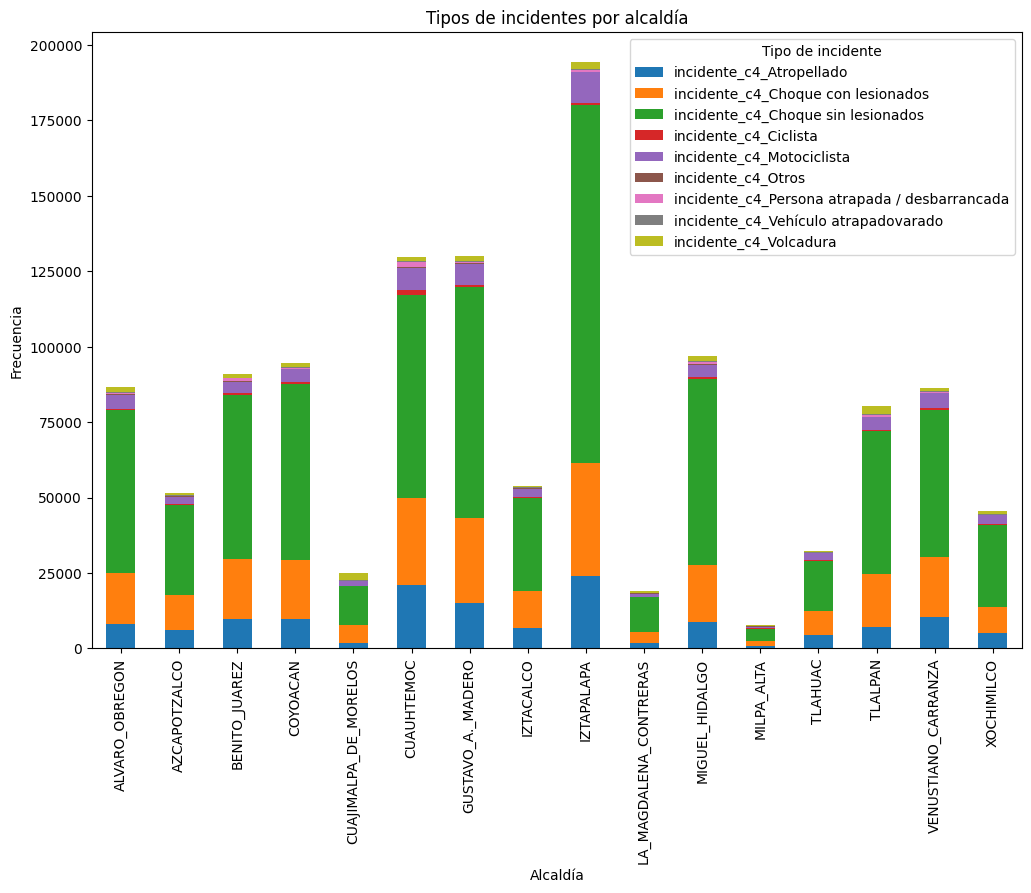

In [278]:
incidentes_alcaldia.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Tipos de incidentes por alcaldía')
plt.xlabel('Alcaldía')
plt.ylabel('Frecuencia')
plt.legend(title='Tipo de incidente')
plt.show()

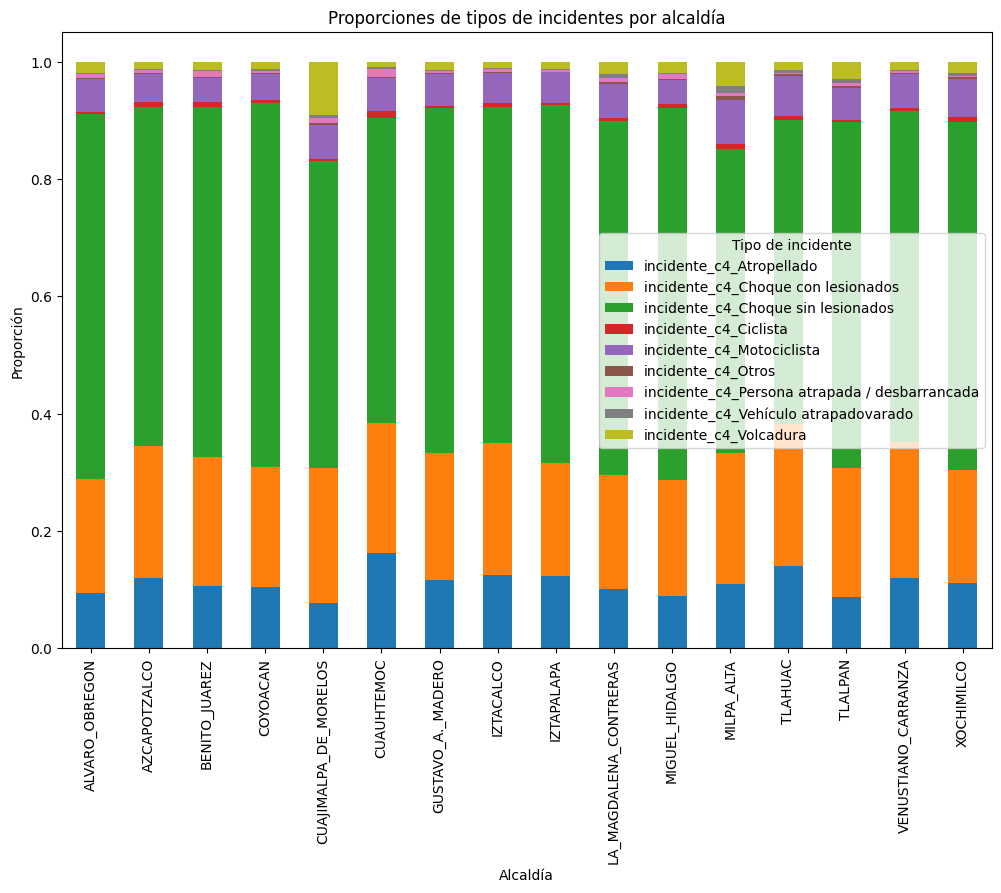

In [279]:
incidentes_alcaldia_proporciones = incidentes_alcaldia.div(incidentes_alcaldia.sum(axis=1), axis=0)

# Crear el gráfico de barras apiladas con proporciones
incidentes_alcaldia_proporciones.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Proporciones de tipos de incidentes por alcaldía')
plt.xlabel('Alcaldía')
plt.ylabel('Proporción')
plt.legend(title='Tipo de incidente')
plt.show()

In [280]:
# valores_unicos = data['alcaldia_inicio'].unique()

# # Crear un diccionario de DataFrames, donde cada clave es un valor único de 'alcaldia_creacion'
# dataframes_por_alcaldia = {}

# for valor in valores_unicos:
#     # Filtrar el DataFrame para incluir solo las filas donde alcaldia_creacion es el valor actual
#     nombre_dataframe = f"data_{valor}"
#     globals()[nombre_dataframe] = data[data['alcaldia_inicio'] == valor]

# # Mostrar los nombres de los nuevos DataFrames
# for valor in valores_unicos:
#     nombre_dataframe = f"data_{valor.upper()}"
#     print(f"Nombre del DataFrame para {valor}: {nombre_dataframe}")
#     print(eval(nombre_dataframe))  # Muestra el DataFrame correspondiente


In [281]:
data['alcaldia_inicio'].value_counts()

alcaldia_inicio
IZTAPALAPA                194425
GUSTAVO_A._MADERO         130148
CUAUHTEMOC                129657
MIGUEL_HIDALGO             96970
COYOACAN                   94475
BENITO_JUAREZ              90957
ALVARO_OBREGON             86635
VENUSTIANO_CARRANZA        86392
TLALPAN                    80232
IZTACALCO                  54002
AZCAPOTZALCO               51361
XOCHIMILCO                 45407
TLAHUAC                    32353
CUAJIMALPA_DE_MORELOS      24869
LA_MAGDALENA_CONTRERAS     18924
MILPA_ALTA                  7768
Name: count, dtype: int64

In [290]:
alcaldia_seleccionada = "BENITO_JUAREZ"
data_alcaldia = data.query("alcaldia_inicio==@alcaldia_seleccionada")
data_alcaldia

,fecha_creacion,hora_creacion,dia_semana,alcaldia_inicio,latitud,longitud,codigo_cierre,tipo_entrada,sin_enc_hora_creacion,cos_enc_hora_creacion,dia,mes,año,semana,sin_enc_fecha_creacion,cos_enc_fecha_creacion,incidente_c4_Atropellado,incidente_c4_Choque con lesionados,incidente_c4_Choque sin lesionados,incidente_c4_Ciclista,incidente_c4_Motociclista,incidente_c4_Otros,incidente_c4_Persona atrapada / desbarrancada,incidente_c4_Vehículo atrapadovarado,incidente_c4_Volcadura,codigo_cierre_binario
30,2014-01-01,15.872500,Miércoles,BENITO_JUAREZ,19.357360,-99.144010,A,LLAMADA DEL 911,-0.848856,-0.528624,1,1,2014,1,0.017213,0.999852,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
77,2014-01-01,7.327500,Miércoles,BENITO_JUAREZ,19.381550,-99.191550,A,RADIO,0.940214,-0.340585,1,1,2014,1,0.017213,0.999852,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
86,2014-01-01,10.121389,Miércoles,BENITO_JUAREZ,19.395050,-99.180590,A,RADIO,0.472230,-0.881475,1,1,2014,1,0.017213,0.999852,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1
129,2014-01-01,10.630833,Miércoles,BENITO_JUAREZ,19.384980,-99.141470,A,RADIO,0.350820,-0.936443,1,1,2014,1,0.017213,0.999852,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
140,2014-01-01,2.797500,Miércoles,BENITO_JUAREZ,19.368990,-99.168490,A,LLAMADA DEL 911,0.668644,0.743583,1,1,2014,1,0.017213,0.999852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1974076,2023-07-31,17.127500,Lunes,BENITO_JUAREZ,19.383846,-99.174064,A,RADIO,-0.974025,-0.226439,31,7,2023,31,-0.486273,-0.873807,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1974089,2023-07-30,21.489722,Domingo,BENITO_JUAREZ,19.401086,-99.147085,A,LLAMADA DEL 911,-0.610894,0.791712,30,7,2023,30,-0.471160,-0.882048,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1974136,2023-07-31,12.559444,Lunes,BENITO_JUAREZ,19.395399,-99.143050,F,LLAMADA DEL 911,-0.145939,-0.989294,31,7,2023,31,-0.486273,-0.873807,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1974149,2023-07-31,13.737222,Lunes,BENITO_JUAREZ,19.378881,-99.159097,I,LLAMADA DEL 911,-0.439286,-0.898347,31,7,2023,31,-0.486273,-0.873807,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0


## FACEBOOK PROPHET

In [318]:

# Agrupar por 'ds' y sumar el número de unos en 'codigo_cierre_binario'
data_fproph = data_alcaldia.groupby(pd.Grouper(key='fecha_creacion', freq='W'))['codigo_cierre_binario'].sum().reset_index()

data_fproph = data_fproph.query('fecha_creacion >= "2014-01-01" and fecha_creacion <= "2023-07-31"')

# Renombrar la columna resultante
data_fproph = data_fproph.rename(columns={'codigo_cierre_binario': 'y', 'fecha_creacion': 'ds'})

# Mostrar el nuevo DataFrame
data_fproph.tail(20)



,ds,y
480,2023-03-19,94
481,2023-03-26,122
482,2023-04-02,117
483,2023-04-09,80
484,2023-04-16,109
485,2023-04-23,153
486,2023-04-30,118
487,2023-05-07,95
488,2023-05-14,119
489,2023-05-21,127


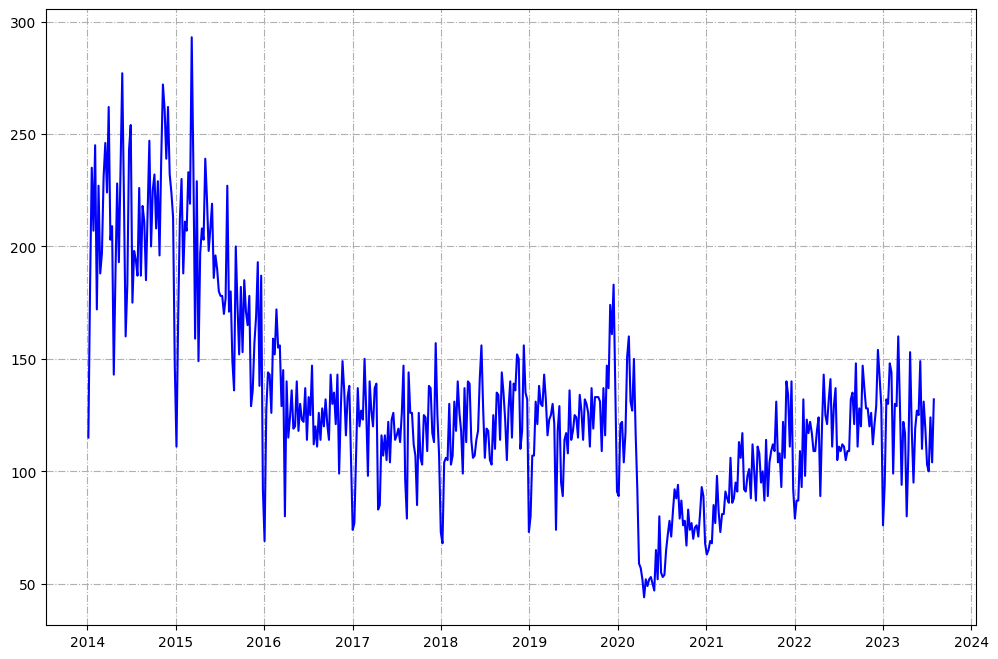

In [319]:
plt.figure(figsize=(12, 8))
plt.grid(linestyle='-.')

plt.plot(data_fproph['ds'], data_fproph['y'], 'b')
plt.show()
	

In [320]:
data_fproph.shape

(500, 2)

In [328]:
train = data_fproph.iloc[:round(len(data_fproph)*0.9)]
test = data_fproph.iloc[round(len(data_fproph)*0.9):]

In [329]:
# cutoff = round(len(data_fproph)*0.7)
# train = data_fproph.iloc[:cutoff]
# test = data_fproph.iloc[cutoff:]

In [330]:
train.shape, test.shape

((450, 2), (50, 2))

In [347]:
model = Prophet(changepoint_prior_scale=0.1, seasonality_prior_scale=0.01, weekly_seasonality=False)
model.add_seasonality(name='custom_weekly', period=7, fourier_order=3)  # Puedes ajustar el fourier_order según la complejidad

model.fit(train)

14:47:48 - cmdstanpy - INFO - Chain [1] start processing
14:47:48 - cmdstanpy - INFO - Chain [1] done processing


In [348]:
# forecast.loc[cutoff:, 'yhat']
# test["y"]

In [349]:
horizon = 120
future = model.make_future_dataframe(periods=horizon, freq='W')

#} y_true = test.tail(horizon)

forecast = model.predict(future)
# forecast['mae'] = mean_absolute_error(y_true, forecast['yhat'])

# # Calcular MAPE para cada fila
# forecast['mape'] = abs((y_true - forecast['yhat']) / y_true) * 100

forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(50)

,ds,yhat,yhat_lower,yhat_upper
520,2023-12-24,143.331244,110.904406,177.688307
521,2023-12-31,124.777121,92.104759,158.617347
522,2024-01-07,120.857189,89.576894,154.829324
523,2024-01-14,133.105547,99.473214,168.207587
524,2024-01-21,150.531200,113.623846,184.851743
525,2024-01-28,160.583439,126.738315,196.412406
526,2024-02-04,160.594580,128.493352,195.556775
527,2024-02-11,157.959800,123.033363,191.987026
528,2024-02-18,160.167379,126.012236,193.416298
529,2024-02-25,166.586568,131.649883,203.707477


/home/alaracster/.pyenv/versions/3.10.6/envs/cdmx911_project/lib/python3.10/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/alaracster/.pyenv/versions/3.10.6/envs/cdmx911_project/lib/python3.10/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/home/alaracster/.pyenv/versions/3.10.6/envs/cdmx911_project/lib/python3.10/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated,

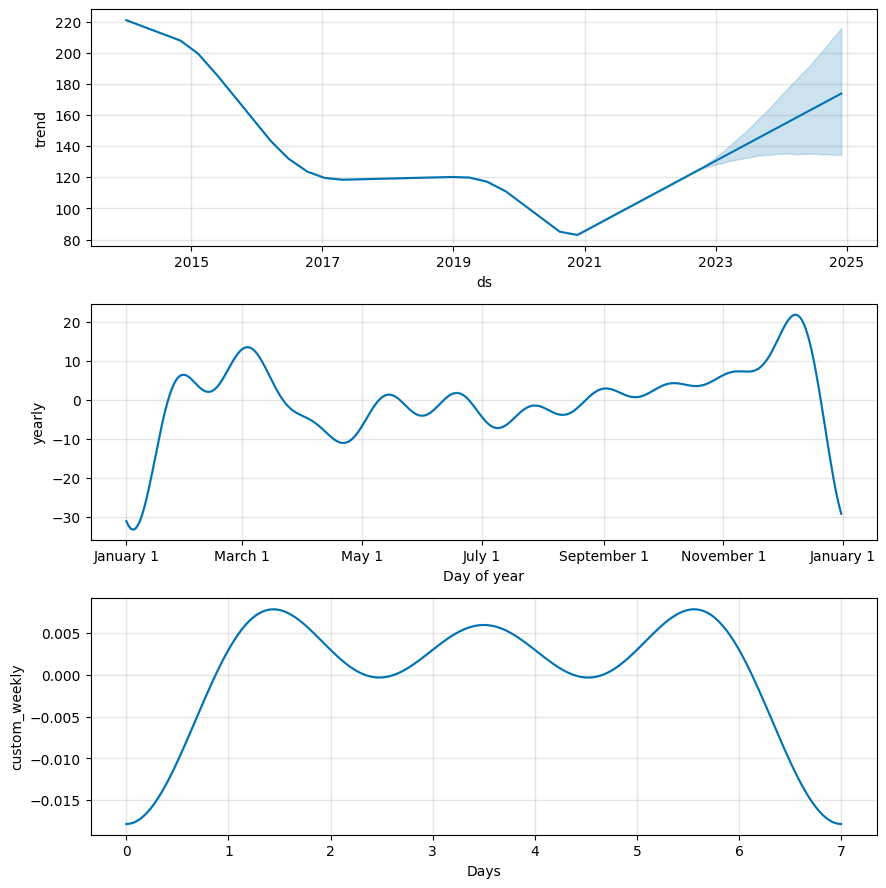

In [350]:
fig = model.plot_components(forecast)

In [351]:
train.tail()

,ds,y
445,2022-07-17,112
446,2022-07-24,111
447,2022-07-31,105
448,2022-08-07,109
449,2022-08-14,109


/home/alaracster/.pyenv/versions/3.10.6/envs/cdmx911_project/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/alaracster/.pyenv/versions/3.10.6/envs/cdmx911_project/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


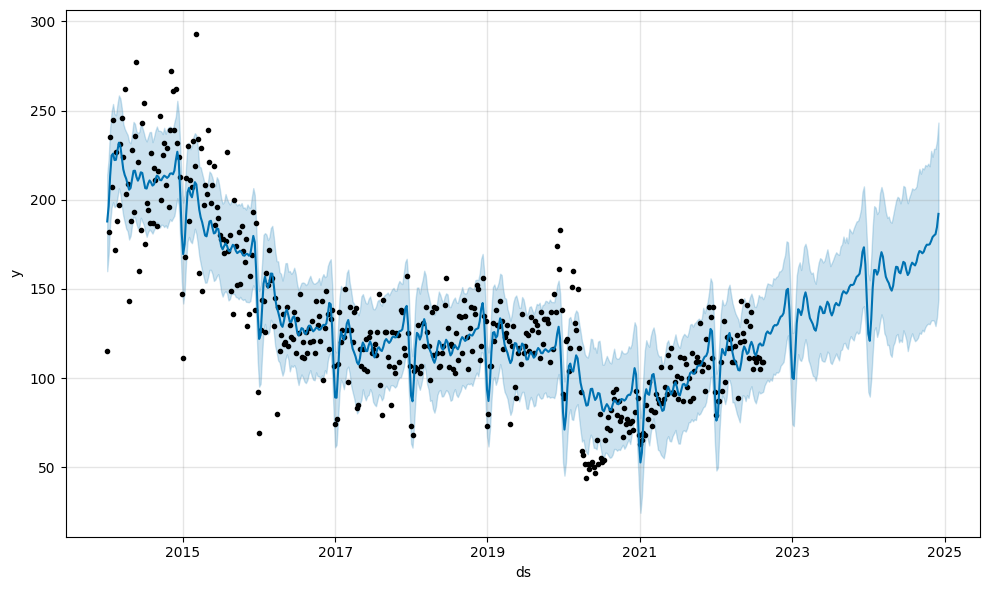

In [352]:
ax = model.plot(forecast)

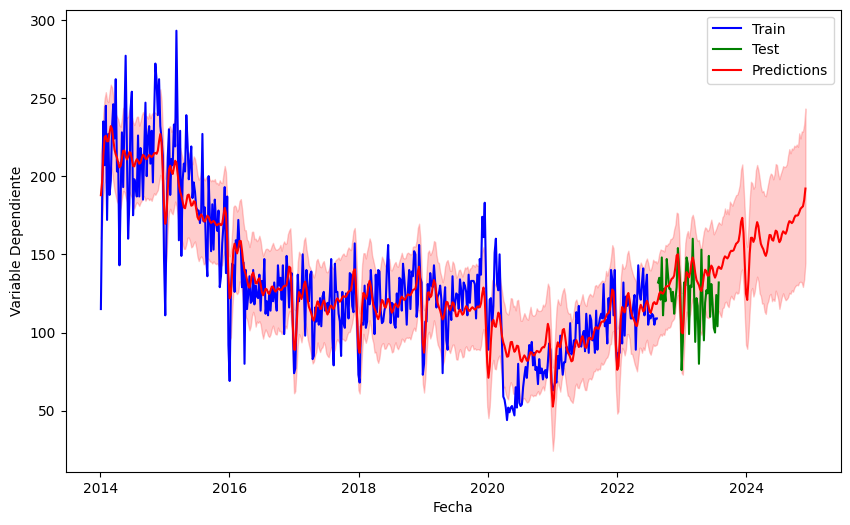

In [353]:

forecast2 = model.predict(test)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(train['ds'], train['y'], label='Train', color='blue')
ax.plot(test['ds'], test['y'], label='Test', color='green')
ax.plot(forecast['ds'], forecast['yhat'], label='Predictions', color='red')
ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='red', alpha=0.2)

ax.set_xlabel('Fecha')
ax.set_ylabel('Variable Dependiente')
ax.legend()
plt.show()

In [354]:
cv_results = cross_validation(model=model, initial=f'{365 * 7} days', horizon='211 days', period='180 days')
cv_results

  0%|                                                                                             | 0/3 [00:00<?, ?it/s]14:47:59 - cmdstanpy - INFO - Chain [1] start processing
14:47:59 - cmdstanpy - INFO - Chain [1] done processing
 33%|████████████████████████████▎                                                        | 1/3 [00:00<00:00,  8.05it/s]14:47:59 - cmdstanpy - INFO - Chain [1] start processing
14:47:59 - cmdstanpy - INFO - Chain [1] done processing
 67%|████████████████████████████████████████████████████████▋                            | 2/3 [00:00<00:00,  7.90it/s]14:47:59 - cmdstanpy - INFO - Chain [1] start processing
14:47:59 - cmdstanpy - INFO - Chain [1] done processing
100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.85it/s]


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2021-01-24,71.683307,45.812523,100.694259,68,2021-01-20
1,2021-01-31,73.501205,46.489122,101.270635,85,2021-01-20
2,2021-02-07,68.415836,40.890908,96.324315,77,2021-01-20
3,2021-02-14,66.556876,37.076832,93.203488,98,2021-01-20
4,2021-02-21,71.607454,44.102704,99.776459,82,2021-01-20
...,...,...,...,...,...,...
86,2022-07-17,96.837234,68.949652,122.940698,112,2022-01-15
87,2022-07-24,100.193061,72.439610,129.737471,111,2022-01-15
88,2022-07-31,101.064370,74.662354,129.014472,105,2022-01-15
89,2022-08-07,99.569848,72.979011,129.827926,109,2022-01-15


In [355]:
df_p = performance_metrics(cv_results)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,20 days,376.773546,19.410655,14.984593,0.152340,0.131624,0.170269,0.777778
1,22 days,471.995574,21.725459,17.945428,0.173571,0.135280,0.194544,0.666667
2,25 days,580.340383,24.090255,21.029852,0.203202,0.140096,0.231146,0.555556
3,27 days,627.459497,25.049142,22.334438,0.215624,0.222758,0.246428,0.555556
4,29 days,618.407426,24.867799,21.575989,0.208958,0.222758,0.239295,0.555556
...,...,...,...,...,...,...,...,...
78,202 days,1839.578626,42.890309,36.114715,0.333247,0.377059,0.436293,0.444444
79,204 days,1823.913991,42.707306,35.477757,0.327818,0.377059,0.430206,0.444444
80,207 days,1948.855999,44.145849,36.812594,0.337481,0.377059,0.447688,0.444444
81,209 days,1866.301777,43.200715,35.663765,0.330461,0.313877,0.437426,0.555556


In [356]:
from sklearn.model_selection import ParameterGrid

# Define las métricas que te interesan
metrics = ['mae', 'mape']

# Crea una lista para almacenar los resultados de cada combinación de hiperparámetros
results = []

# Define el rango de parámetros a probar
param_grid = {'weekly_seasonality': [True, False],
              'changepoint_prior_scale': [0.01, 0.1, 0.5],
              'seasonality_prior_scale': [0.01, 0.1, 1.0]}

# Itera sobre todas las combinaciones de hiperparámetros
for params in ParameterGrid(param_grid):
    # Asigna los hiperparámetros al modelo existente
    model = Prophet(**params)
    
    # Ajusta el modelo al conjunto de entrenamiento
    model.fit(train)

    # Realiza validación cruzada y obtén las métricas de rendimiento
    cv_results = cross_validation(model=model, initial=f'{365 * 7} days', horizon='211 days', period='180 days')
    df_p = performance_metrics(cv_results)

    # Almacena las métricas en la lista de resultados
    result_entry = {'params': params}
    for metric in metrics:
        result_entry[metric] = df_p[metric].values[0]

    results.append(result_entry)

# Convierte los resultados a un DataFrame para facilitar el análisis
results_df = pd.DataFrame(results)

# Muestra las mejores combinaciones de hiperparámetros según las métricas
best_params_mae = results_df.sort_values(by='mae').iloc[0]['params']
best_params_mape = results_df.sort_values(by='mape').iloc[0]['params']

print("Mejores hiperparámetros según MAE:", best_params_mae)
print("Mejores hiperparámetros según MAPE:", best_params_mape)

14:48:06 - cmdstanpy - INFO - Chain [1] start processing
14:48:06 - cmdstanpy - INFO - Chain [1] done processing
  0%|                                                                                             | 0/3 [00:00<?, ?it/s]14:48:06 - cmdstanpy - INFO - Chain [1] start processing
14:48:06 - cmdstanpy - INFO - Chain [1] done processing
14:48:06 - cmdstanpy - INFO - Chain [1] start processing
14:48:06 - cmdstanpy - INFO - Chain [1] done processing
 67%|████████████████████████████████████████████████████████▋                            | 2/3 [00:00<00:00, 10.00it/s]14:48:06 - cmdstanpy - INFO - Chain [1] start processing
14:48:06 - cmdstanpy - INFO - Chain [1] done processing
100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.70it/s]
14:48:06 - cmdstanpy - INFO - Chain [1] start processing
14:48:06 - cmdstanpy - INFO - Chain [1] done processing
  0%|                                                                     

Mejores hiperparámetros según MAE: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'weekly_seasonality': True}
Mejores hiperparámetros según MAPE: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'weekly_seasonality': True}


In [359]:
directory = '../raw_data/'

file = f"{alcaldia_seleccionada}_pred.csv"

full_path = os.path.join(directory, file)

forecast_final = forecast[['ds', 'yhat']].tail(20)

forecast_final = forecast_final.rename(columns={'ds': 'semana_creacion', 'yhat': 'numero_incidentes'})

forecast_final.to_csv(full_path, index=False)

# Imprime un mensaje indicando que el archivo se ha guardado exitosamente
print(f"El archivo {full_path} se ha guardado exitosamente.")


El archivo ../raw_data/BENITO_JUAREZ_pred.csv se ha guardado exitosamente.
